# Assignment 2

## Problem 1A
---
### (1)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import bisect
from tqdm import tqdm

Since in atomic  units $\hbar = m_e = 1$ so $\omega = \sqrt{2}$. Hence the $V(x)=x^2$.

In [3]:
# Define Potential
@np.vectorize
def V(x):
    # in atomic units
    return x**2

To estimate domain, we use go bit larger than the classical region $x = \pm \sqrt{mE} = \pm \sqrt{m \hbar \omega (n + \frac{1}{2})} = \pm \sqrt{ \sqrt{2} (n + 0.5)} $ . Say 1.5 times.

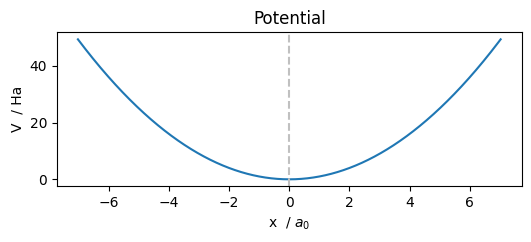

In [17]:
# Define domain
xL = -1.5*np.sqrt(np.sqrt(2)*(15+0.5)) 
xR = -xL

# We have observed that for junction condn calcultn xm must be 0.0.
# No other value will do. But for actula wavefucntion calulation, xm MUST be non zero.

xm = 0.5 # point for matching junction condtions
dx = 1./100 # stepsize

# Create domain points
x = np.linspace(xL, xR, int((xR-xL)/dx)+1)

# plot potential to check
plt.figure(figsize=(6,2))
plt.plot(x, V(x))
plt.axvline(0, ls='--', c='silver')
plt.xlabel('x  / $a_0$')
plt.ylabel('V  / Ha')
plt.title('Potential')
plt.show()

### TISE

The 1D time-independent Schrodinger equation can be written as a set of two coupled first order ODEs:

\begin{align}
\frac{du}{dx} &= w \\
\frac{dw}{dx} &= 2 \left (V(x) - E \right ) u
\end{align}

which is denoted in a vectorized format as:
\begin{equation}
\frac{d \vec \psi}{dx} = \text{RHS},
\end{equation}
where $\vec \psi = \begin{bmatrix} u(x) \\ w(x) \end{bmatrix}$, 
and $\text{RHS} = \begin{bmatrix} w(x) \\ 2 \left (V(x) - E \right ) u(x) \end{bmatrix}$.


In [19]:
# Define derivative function.
def dPsi_dx(x, psi, E):

    # u , v are as explained in the above markdown
    u, w = psi
    
    dudx = w
    dwdx = 2*(V(x) - E)*u
    
    dpsidx = [dudx, dwdx]
    
    return np.asarray(dpsidx)

Vectorised RK2 solver.

In [20]:
# Use RK2 to define Solver function.
def solveTISE(E, xL, xR, xm, dx):
    # We will use a vectorized form of RK2 solver

    #-- Left --> Right solution in the domain [xL, xm]
    x1 = np.linspace(xL, xm, int((xm-xL)/dx)+1)
    psiL = np.zeros((2, len(x1)))
    psiL[:, 0] = [0., 0.1]    #-- initial condition
    
    for k in range(1, len(x1)):
        k1 = dPsi_dx(x1[k-1], psiL[:, k-1], E)
        psiL_half = psiL[:, k-1] + k1*dx/2
        k2 = dPsi_dx(x1[k], psiL_half, E)
        psiL[:, k] = psiL[:, k-1] + k2*dx

    #-- Right --> Left solution in the domain [xR, xm]
    x2 = np.linspace(xR, xm, int((xR-xm)/dx)+1)
    psiR = np.zeros((2, len(x2)))
    psiR[:, 0] = [0., -0.1]   #-- initial condition

    for k in range(1, len(x2)):  
        k1 = dPsi_dx(x2[k-1], psiR[:, k-1], E)
        psiR_half = psiR[:, k-1] - k1*dx/2 
        k2 = dPsi_dx(x2[k], psiR_half, E)
        psiR[:, k] = psiR[:, k-1] - k2*dx

    #-- adjust the sign between L and R solutions
    C = np.sign(psiR[0, -1]/psiL[0, -1]) 
    psiR = C * psiR

    return psiL, psiR
    

In [22]:
# Define the junction condition function
@np.vectorize
def juncCondn(E):
    # xL, xR, xm, dx = -7.5, 7.5, 0.0, 1./200

    # print(xL,xR,dx,xm)
    psiL, psiR = solveTISE(E, xL, xR, 0.0 , dx)

    jump = psiL[1, -1]/psiL[0, -1] - psiR[1, -1]/psiR[0, -1]

    return jump

Scan the energy landscape upto estimated range of E for desired number of eigenvalues. The step in energy domian need not be too small since the energ eignvalue of harmonic oscillator are know to have good gap.

In [24]:
Emin = 0 # minimum of energy
Emax = np.sqrt(2)*(15 + 0.5) # desired range for 15 eigenstate
step = 0.1 # step in energy domian.
N = int((Emax-Emin)/step)
jc = np.zeros(N)
En = np.zeros(N)

for i in tqdm(range(N)):
    E = Emin + step*i
    En[i] = E
    jc[i] = juncCondn(E)

100%|██████████| 219/219 [00:11<00:00, 19.78it/s]


Plot junction values for differnt energies.

Text(0, 0.5, 'junction value')

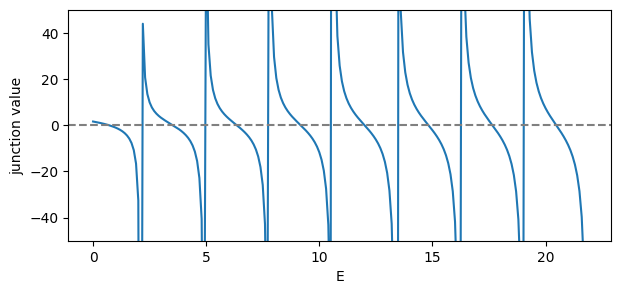

In [30]:
plt.figure(figsize=(7,3))
plt.ylim(-50,50)
plt.plot(En, jc)
plt.axhline(0,c='grey',ls='--')
plt.xlabel('E')
plt.ylabel('junction value')

Using the sign change condition and bisection method find the energy eigenvalues.

In [29]:
#-- Where does the juncCondn change sign
#-- The eigenvalues are likely to be found near these points
# returns index where sign change happens
idx = np.where(jc[:-1] * jc[1:] < 0 )[0] +1 

EigValues = np.zeros(len(idx))

for j in range(len(idx)):
    a = En[idx[j]-1]
    b = En[idx[j]+1]
    EigValues[j] = bisect(juncCondn, a, b)
    print (j+1, 'approximate eigValue =', En[idx[j]], 'True eigValue =', EigValues[j])

1 approximate eigValue = 0.8 True eigValue = 0.7026197384329863
2 approximate eigValue = 2.2 True eigValue = 2.112564563319029
3 approximate eigValue = 3.6 True eigValue = 3.524785701175279
4 approximate eigValue = 5.0 True eigValue = 4.936905989593652
5 approximate eigValue = 6.4 True eigValue = 6.349520792947444
6 approximate eigValue = 7.800000000000001 True eigValue = 7.762035714373632
7 approximate eigValue = 9.200000000000001 True eigValue = 9.174748017052481
8 approximate eigValue = 10.600000000000001 True eigValue = 10.587360693361552
9 approximate eigValue = 12.100000000000001 True eigValue = 12.00005939204857
10 approximate eigValue = 13.5 True eigValue = 13.412658595033282
11 approximate eigValue = 14.9 True eigValue = 14.825288187309347
12 approximate eigValue = 16.3 True eigValue = 16.237818379742386
13 approximate eigValue = 17.7 True eigValue = 17.650346545084908
14 approximate eigValue = 19.1 True eigValue = 19.06277539447037
15 approximate eigValue = 20.5 True eigValue

Plot to show that the energy eignvalues are uniformly spaced.

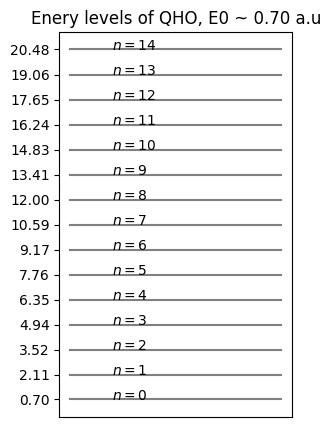

In [32]:
plt.figure(figsize=(3,5))
for i in range(len(EigValues)):
    y = EigValues[i]
    l = np.sqrt(y)
    L = 2*np.abs(x[-1])
    plt.text(0.2,y,'$n=$'+str(i))
    plt.plot((0,1 ),(y,y ),c='grey')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.yticks(EigValues)
plt.title('Enery levels of QHO, E0 ~ 0.70 a.u')
plt.show()

#### **Comparison with exact value.** 
Since the exact ground state energy is $E_0 = \frac{\hbar \omega}{2}$ which in atomic units becomes  $$E_0 = \frac{1 \sqrt{2}}{2}= \frac{1}{\sqrt{2}} \approx 0.707$$ 
whereas the numerical value is $$E_0 = 0.702$$ 
so they are in good agreement.

We can also plot these eigenfunctions.

In [ ]:
# plt.figure(figsize=(12,8))

# for j in range(len(idx)):

#     plt.subplot(5, 3, j+1)
#     psiL, psiR = solveTISE(EigValues[j], xL, xR,0.1, dx)
    
#     psi = np.hstack( (psiL[0, :], np.flipud(psiR[0, :-1])) )

#     # x = np.arange(-7.5, 7.5+(1./200), 1./200)
#     plt.plot(x, V(x)/100, '-', c='silver', label='V(x)/200')
#     plt.plot(x, psi/np.linalg.norm(psi), label='%.4f'%(EigValues[j]))
    
#     plt.legend()


# plt.show()

---
## (2)

We first create $| \psi_0 \rangle $ and  $| \psi_1 \rangle $ and normalise them and then define $$| \psi_{01} \rangle = | \psi_0 \rangle + | \psi_1 \rangle$$ and normalise it.

In [46]:
psiL, psiR = solveTISE(EigValues[0], xL, xR, xm, dx)
psi = np.hstack( (psiL[0, :], np.flipud(psiR[0, :-1])) )
psi0 = psi/np.linalg.norm(psi)

psiL, psiR = solveTISE(EigValues[1], xL, xR, xm, dx)
psi = np.hstack( (psiL[0, :], np.flipud(psiR[0, :-1])) )
psi1 = psi/np.linalg.norm(psi)

psi_01 = psi0 + psi1
psi_01 = psi_01/np.linalg.norm(psi_01)

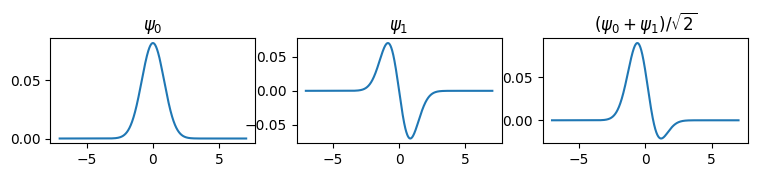

In [44]:
plt.figure(figsize=(9,3))
plt.subplot(2,3,1)
plt.plot(x,psi0)
plt.title('$\psi_0$')
plt.subplot(2,3,2)
plt.plot(x,psi1)
plt.title('$\psi_1$')
plt.subplot(2,3,3)
plt.plot(x,psi_01)
plt.title('$(\psi_0 + \psi_1)/\sqrt{2}$')
plt.show()

Now we create $T$ and $V$ matrix and we will use the fact that $H = T +V$.

In [47]:
N = len(x)

T_mat = np.zeros((N,N)) # T operator matrix
V_mat = np.zeros((N,N)) # V operator matrix

# fill off diagonal terms of T matrix
for i in range(N-1):
    T_mat[i,i+1] = 1
    T_mat[i+1,i] = 1

# fill diagonal terms of T and V matrix
for i in range(N):
    T_mat[i,i] = -2 
    V_mat[i,i] = V(x[i])

T_mat = -T_mat/(2*dx**2)

Calculate expectation values of $T$ and $V$ and use $\langle H \rangle = \langle T \rangle +\langle V \rangle $.

In [49]:
T_exp = np.matmul(psi_01,np.matmul(T_mat,psi_01))
V_exp = np.matmul(psi_01,np.matmul(V_mat,psi_01))
print('<T> = ',T_exp )
print('<V> = ',V_exp )
print('<H> = ',T_exp + V_exp )

<T> =  0.7056744018262178
<V> =  0.7089254281756618
<H> =  1.4145998300018796


So we see that $$ \langle T \rangle = \langle V \rangle = \frac{\langle H \rangle}{2} $$
We know that for classical harmonic oscillator the $\langle T \rangle = \langle V \rangle$. And this is also true for Quantum Harmonic oscillator. Given that the state vector $| \psi \rangle$ is either stationary state, a coherent state or superposition of adjacent states, which is the case here. This is not true for instance for state  $| \psi_{02} \rangle = | \psi_0 \rangle + | \psi_2 \rangle$ 

---
---
# Problem 1B

---
## (1)

Numerov method gives us a three term recursion relation for $\psi_{i+1}$. Now if the differntial equation contains first order derivative , then applying $\left( 1 + \frac{h^2}{12} \frac{d^2}{dx^2}\right)$ on the differntial equation will lead to first order derivative terms. So we won't be able to express $\psi''$ in terms of only $\psi$. 

---
## (2)

The three term recursion relation for $\psi$ is
\begin{equation}
\psi_{i+1} = \frac{ 2\left( 1 - \frac{5h^2}{12}f_{i} \right) \psi_{i} - \left( 1 + \frac{h^2}{12}f_{i-1} \right) \psi_{i-1}  }{ 1 + \frac{h^2}{12}f_{i+1}}
\end{equation}

As we can see to calculate $\psi_2$ we need $\psi_1$ and $\psi_0$. But for a given boundary value problem we only have $\psi_0$. So we first need to use another method to find $\psi_1$ then we can obtain rest of the $\psi_i$ recursively. So the method is not self starting.

For each $\psi_i$, Numerov method makes 3 calls to the function $f$. But two of which can be use from previous step. So effectivly it makes only one function call per step. Whereas RK2 makes 2 and RK4 makes 4 function call for each psi. So Numerov is faster.

---
## (3)
**Expression for $\psi'$** 

$$\psi(x+h) = \psi(x) + \psi'(x)h + \psi''(x)\frac{h^2}{2} + \psi'''(x)\frac{h^3}{6} + \mathcal O(h^4)$$
$$\psi(x-h) = \psi(x) - \psi'(x)h + \psi''(x)\frac{h^2}{2} - \psi'''(x)\frac{h^3}{6} + \mathcal O(h^4)$$

Subtracting these two will give:
$$\psi(x+h) - \psi(x-h) =  2 \psi'(x)h  + \psi'''(x)\frac{h^3}{3} + \mathcal O(h^5)$$

Now using the differential equation $$\psi''(x) + f(x)\psi(x) = 0  \implies \psi'''(x) = - (f(x)\psi(x))' $$
We approximate by central difference 
$$ (f(x)\psi(x))' = \frac{f(x+h)\psi(x+h) - f(x-h)\psi(x-h) }{2h} + \mathcal O(h^2)$$

Subtituting this for the third derivative in the third equation we get 
\begin{align*}
\psi(x+h) - \psi(x-h) &=  2 \psi'(x)h  - \left( \frac{f(x+h)\psi(x+h) - f(x-h)\psi(x-h) }{2h} + \mathcal O(h^2) \right)\frac{h^3}{3} + \mathcal O(h^5) \\
                      &=  2 \psi'(x)h  +  \frac{-f(x+h)\psi(x+h) + f(x-h)\psi(x-h) }{6} {h^3} + \mathcal O(h^5) \\
\end{align*}

Rearranging this gives for $\psi'$  gives
$$ \psi'(x) = \frac{ \left[ 1 + \frac{h^2}{6}f(x+h) \right] \psi(x+h) - \left[ 1 + \frac{h^2}{6}f(x-h) \right] \psi(x-h)  }{2h} + \mathcal O(h^4)$$

or

$$ \boxed{ \psi'_{i}= \frac {1}{2h} \left[ \left( 1+ \frac{h^2}{6}f_ {i+1} \right) \psi_{i+1} - \left(1+ \frac{h^2}{6}f_{i-1} \right)\psi_{i-1} \right]+O(h^4) }
$$

---
---
#  Problem 2
(1 min 28 sec execution time)

Numerov Solver

In [4]:
def dPsi_dx(x, psi, E):
    
    u, w = psi
    
    dudx = w
    dwdx = 2*(V(x) - E)*u
    
    dpsidx = [dudx, dwdx]
    
    return np.asarray(dpsidx)

def solveTISE(E, xL, xR, xm, dx):
    # We will use a vectorized form of RK2 solver

    #-- Left --> Right solution in the domain [xL, xm+dx]======================================
    x1 = np.linspace(xL, xm+dx, int((xm+dx-xL)/dx)+1)
    psiL = np.zeros((2, len(x1)))
    psiL[:, 0] = [0., 0.1]    #-- initial condition
    

    # update first using RK2
    k1 = dPsi_dx(x1[0], psiL[:,0], E)
    psiL_half = psiL[:, 0] + k1*dx/2
    k2 = dPsi_dx(x1[1], psiL_half, E)
    psiL[:, 1] = psiL[:, 0] + k2*dx
    # print('First step updated using RK2')

    # Numerov----------------------------
    f_i = 2*(E-V(x1[1]))
    f_im1 = 2*(E-V(x1[0]))

    for i in range(1,len(x1)-1):

        f_ip1 = 2*(E-V(x1[i+1]))

        l_i = 2*(1 - (5*dx**2*f_i)/12 )
        l_im1 = (1 + (dx**2*f_im1)/12 )
        l_ip1 = (1 + (dx**2*f_ip1)/12 )

        psiL[0, i+1] = (l_i*psiL[0,i] - l_im1*psiL[0,i-1])/l_ip1

        f_im1 = f_i
        f_i = f_ip1

    #-- Right --> Left solution in the domain [xR, xm]=======================================================
    x2 = np.linspace(xR, xm-dx, int((xR-xm+dx)/dx)+1)
    psiR = np.zeros((2, len(x2)))
    psiR[:, 0] = [0., -0.1]   #-- initial condition
    
    # update first using RK2
    k1 = dPsi_dx(x2[0], psiR[:, 0], E)
    psiR_half = psiR[:, 0] - k1*dx/2 
    k2 = dPsi_dx(x2[1], psiR_half, E)
    psiR[:, 1] = psiR[:, 0] - k2*dx

    # Numerov--------------------------------

    f_i = 2*(E-V(x2[1]))
    f_im1 = 2*(E-V(x2[0]))

    for i in range(1,len(x2)-1):

        f_ip1 = 2*(E-V(x2[i+1]))

        l_i = 2*(1 - (5*dx**2*f_i)/12 )
        l_im1 = (1 + (dx**2*f_im1)/12 )
        l_ip1 = (1 + (dx**2*f_ip1)/12 )
        psiR[0, i+1] = (l_i*psiR[0,i] - l_im1*psiR[0,i-1])/l_ip1

        f_im1 = f_i
        f_i = f_ip1


    #-- adjust the sign between L and R solutions
    # now we use second last elemst becasue we have goove one
    # step beyond the xm
    C = np.sign(psiR[0, -2]/psiL[0, -2]) 
    psiR = C * psiR


    # Psi dash : L-->R =======================================================
    
    f_i = 2*(E-V(x1[i]))
    f_im1 = 2*(E-V(x1[i-1]))

    for i in range(1,len(x1)-1):

        f_ip1 = 2*(E-V(x1[i+1]))

        l_ip1 = ( 1 + dx**2*f_ip1/6)
        l_im1 = ( 1 + dx**2*f_im1/6)

        psiL[1,i] = ( l_ip1*psiL[0,i+1] - l_im1*psiL[0,i-1] )/(2*dx)
        
        f_im1 = f_i
        f_i = f_ip1

    # Psi_dash:R-->L ==========================================================
    f_i = 2*(E-V(x2[i]))
    f_im1 = 2*(E-V(x2[i-1]))

    for i in range(1,len(x2)-1):

        f_ip1 = 2*(E-V(x2[i+1]))

        l_ip1 = ( 1 + dx**2*f_ip1/6)
        l_im1 = ( 1 + dx**2*f_im1/6)

        psiR[1,i] = ( l_ip1*psiR[0,i+1] - l_im1*psiR[0,i-1] )/(-2*dx)
        
        f_im1 = f_i
        f_i = f_ip1

    return psiL[:,0:-1], psiR[:,0:-1]
    


To find energy eigenvalues of differnt number of wells and show splitting.

For  1  well: 


  0%|          | 0/599 [00:00<?, ?it/s]

100%|██████████| 599/599 [00:13<00:00, 42.81it/s]


1 approximate eigValue = -4.073578595349833 True eigValue = -4.081186873542843
2 approximate eigValue = -0.04013377936354523 True eigValue = -0.047811540310037724


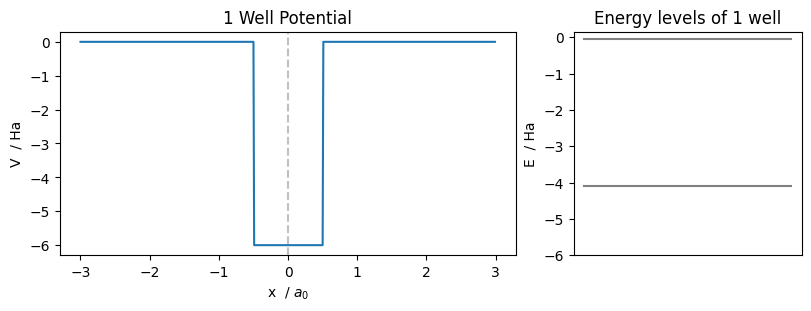

For  2  well: 


100%|██████████| 599/599 [00:03<00:00, 165.75it/s]


1 approximate eigValue = -4.354515050194649 True eigValue = -4.362575139315059
2 approximate eigValue = -3.852842809400334 True eigValue = -3.8553906555016564
3 approximate eigValue = -0.26086956531304306 True eigValue = -0.26119847592057377


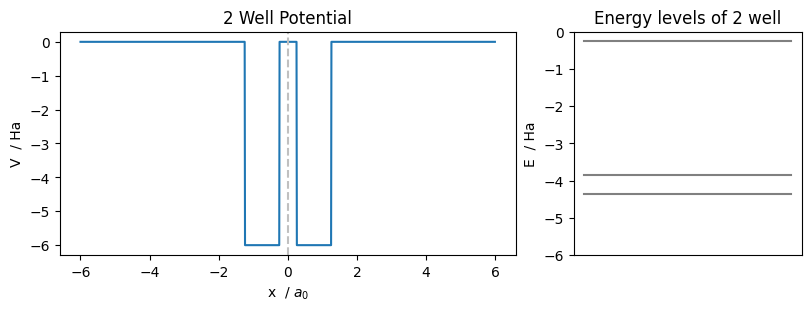

For  4  well: 


100%|██████████| 599/599 [00:09<00:00, 60.54it/s]


1 approximate eigValue = -4.494983277617057 True eigValue = -4.495242056165621
2 approximate eigValue = -4.284280936483444 True eigValue = -4.285872786398655
3 approximate eigValue = -3.97324414719097 True eigValue = -3.977963644601419
4 approximate eigValue = -3.662207357898495 True eigValue = -3.664771094023123
5 approximate eigValue = -0.39130434791956503 True eigValue = -0.3968567707163344
6 approximate eigValue = -1e-10 True eigValue = -0.004466660648453495


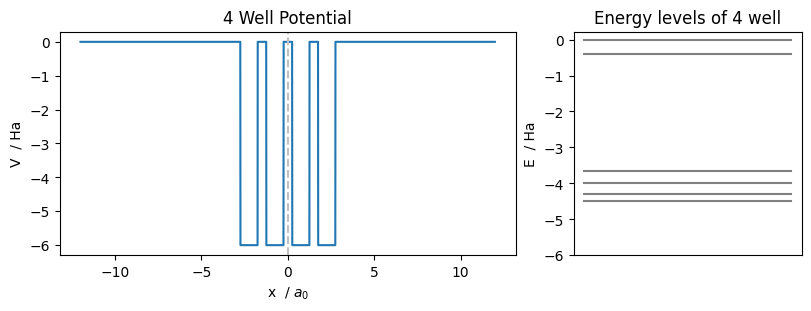

For  8  well: 


100%|██████████| 599/599 [00:32<00:00, 18.29it/s]


1 approximate eigValue = -4.545150501696488 True eigValue = -4.546178382307142
2 approximate eigValue = -4.474916387985284 True eigValue = -4.480411546469925
3 approximate eigValue = -4.364548495010535 True eigValue = -4.373544756868429
4 approximate eigValue = -4.224080267588127 True eigValue = -4.23041431116745
5 approximate eigValue = -4.05351170571806 True eigValue = -4.059477968631264
6 approximate eigValue = -3.872909699032107 True eigValue = -3.87505163721284
7 approximate eigValue = -3.6923076923461537 True eigValue = -3.7004798300917177
8 approximate eigValue = -3.5618729097396318 True eigValue = -3.569886342491139
9 approximate eigValue = -0.4816053512625418 True eigValue = -0.484592026638848
10 approximate eigValue = -0.290969899760702 True eigValue = -0.29448995738412975
11 approximate eigValue = -0.010033444915886314 True eigValue = -0.019535154669957876


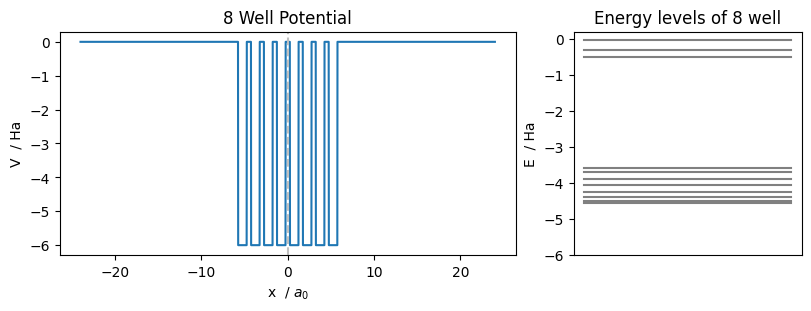

In [5]:
wells = np.array([1,2,4,8]) # these number of wells

for k in range(len(wells)):

    # Define potential-------------------------------------
    a = 1.0   # width of each well
    b = 0.5   # barrier width
    n = wells[k] # n is the number of well

    @np.vectorize
    def V(x):
        
        V0 = 0.  # atomic units
        
        for i in range(-n+1,n+1,2):
            a_i = i*(a+b)/2 # define center of each well

            if np.abs(x-a_i)<a/2:
                V0 = -6
            if np.abs(x-a_i)<a/2:
                V0 = -6

        return V0
    

    # To Plot potential-----------------------------------
    xL = -4*n*(a+b)/2 # left domain 
    xR = 4*n*(a+b)/2  # right domain
    xm = .0
    dx = 0.01 # step to plot potential

    # Set figure size--------------------------------------
    fig = plt.figure(layout='constrained',figsize=(8,3))
    gs = GridSpec(1,3, figure=fig)  # create 1 row, 3 col of above size

    ax1 = fig.add_subplot(gs[0, :2]) # first axis takes 0th row and 0,1 column

    # Plot potential on first axis-----------------
    x = np.arange(xL, xR, dx )
    ax1.plot(x, V(x))
    ax1.axvline(0, ls='--', c='silver')
    ax1.set_title(str(n)+' Well Potential')
    ax1.set_xlabel(r'x  / $a_0$')
    ax1.set_ylabel(r'V  / Ha')

    # junction condition function-----------------------------------------
    @np.vectorize
    def juncCondn(E):

        # for single  well , dx must be 0.01 
        if k==0:
            dxx = 0.01
        else:
            dxx = 0.1
        psiL, psiR = solveTISE(E, xL, xR, 0.0, dxx)

        jump = psiL[1, -1]/psiL[0, -1] - psiR[1, -1]/psiR[0, -1]

        return jump

    # Calulating junction condtion for energy domain---------------------------
    print('For ', n ,' well: ')
    Emin = -6.0 # well minima
    Emax = -1e-10 # to make sure that the last value of E is very close to zero
    step = 0.01 # step size must be larger than the spacing between two closest eigenvalues
    N = int((Emax-Emin)/step)
    En = np.linspace(Emin,Emax,N)
    
    jc = np.zeros(N)
    for i in tqdm(range(N)):
        jc[i] = juncCondn(En[i])

    #-- Where does the juncCondn change sign
    #-- The eigenvalues are likely to be found near these points
    # returns index where sign change happens
    idx = np.where(jc[:-1] * jc[1:] < 0 )[0] +1 

    EigValues = np.zeros(len(idx))

    for j in range(len(idx)):
        aa = En[idx[j]-1]
        bb = En[idx[j]]
        EigValues[j] = bisect(juncCondn, aa, bb)
        print (j+1, 'approximate eigValue =', En[idx[j]], 'True eigValue =', EigValues[j])
    
    # Axis 2 of subplot-------------------------------------
    ax2 = fig.add_subplot(gs[0, 2])  # axis 2 covers 0th row and 2nd index oc column ( i.e third column)
    for i in range(len(EigValues)):
        y = EigValues[i]
        ax2.plot((0,1 ),(y,y ),c='grey')
    
    # to remove x ticks from energy plot
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax2.set_yticks(np.arange(-6,1,1))
    ax2.set_title('Energy levels of '+str(n)+' well')
    ax2.set_ylabel(r'E  / Ha')
    plt.show()


So we see that there are three energy eigenstates for double well. Single well had two energy eigenstates. The ground state (-4.081)  got split into two states, one below it (-4.362 a.u) and one above it (-3.855 a.u). But the excited state of single well was very  close to zero (-0.0478 a.u) so it could not split upward, but it lead to only one state with energy slighlty lower (-0.261 a.u). So the double well has only three energy states.

We see that for eight wells, the bands have become more well-defined and more densely filled, particularly the bottom band. The gap between the bands remains empty.